In [1]:
from adversarial_dataset import AdversarialDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
def show_image(tensor):
    permuted = torch.permute(tensor.cpu(), (1, 2, 0))
    plt.imshow(permuted)

In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.eval()
dataset = AdversarialDataset(annotation_file="images.csv",
                             categories_file="categories.csv",
                             img_dir="images",
                             noise_dir="adversarial_noise_targeted",
                             img_transform=img_transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
dataset[0][0].shape

torch.Size([3, 299, 299])

In [5]:
from sklearn.utils.extmath import randomized_svd

image = dataset[0][0]
img = np.concatenate([image[0, :, :].numpy(), image[1, :, :].numpy(), image[2, :, :].numpy()], axis=1)
U, s, WT = randomized_svd(img, n_components=299, random_state=0)

In [6]:
U.shape, s.shape, WT.shape

((299, 299), (299,), (299, 897))

In [7]:
WT[:100, :].shape

(100, 897)

In [8]:
img.shape, WT.T.shape, WT.shape

((299, 897), (897, 299), (299, 897))

In [9]:
WT_k = WT[:5, :]

In [10]:
X_k = img @ WT_k.T @ WT_k

In [11]:
image.shape, X_k.shape

(torch.Size([3, 299, 299]), (299, 897))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


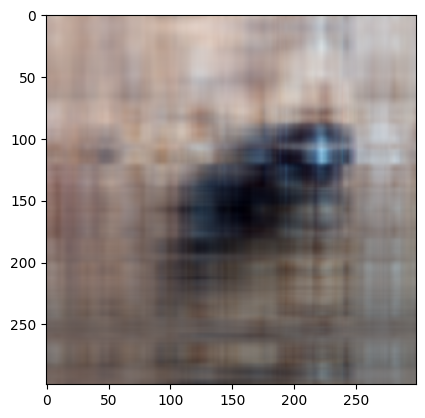

In [12]:
# final_image = np.zeros((image.shape))
# final_image[0, :, :] = X_k[:, :image.shape[1]]
# final_image[1, :, :] = X_k[:, image.shape[1]:image.shape[1]*2]
# final_image[2, :, :] = X_k[:, image.shape[1]*2:image.shape[1]*3]

final_image = np.stack([
    X_k[:, :image.shape[1]],
    X_k[:, image.shape[1]:image.shape[1]*2],
    X_k[:, image.shape[1]*2:image.shape[1]*3]
])

# plt.imshow(final_image, cmap='grey')
show_image(torch.Tensor(final_image))

In [ ]:
kp_set = np.zeros((2*len(dataset), 4))

In [36]:
from sklearn.utils.extmath import randomized_svd

def find_kp_point(image, model):
    n = image.shape[1]
    original_output = model(image[None])
    _, c_original = torch.max(original_output, dim=1)

    img = np.concatenate([image[0, :, :].numpy(), image[1, :, :].numpy(), image[2, :, :].numpy()], axis=1)
    
    try:
        _, _, WT = randomized_svd(img, n_components=299, random_state=0)
    except:
        _, _, WT = randomized_svd(img, n_components=299, random_state=0)
        
    for k in reversed(range(1, n)):
        WT_k = WT[:k, :]
        X_k = img @ WT_k.T @ WT_k

        final_image = np.stack([
            X_k[:, :image.shape[1]],
            X_k[:, image.shape[1]:image.shape[1]*2],
            X_k[:, image.shape[1]*2:image.shape[1]*3]
        ])
        final_image = torch.Tensor(final_image)

        output = model(final_image[None])
        _, c = torch.max(output, dim=1)

        if c != c_original:
            probabilities = torch.nn.functional.softmax(output, dim=1)
            return k, probabilities[0, c].item(), c.item()
        
    print("Oops")
    probabilities = torch.nn.functional.softmax(original_output, dim=1)
    return 1, probabilities[0, c_original].item(), c_original.item()

In [41]:
subset_length = len(dataset)

for i in tqdm(range(2*subset_length)):
    if kp_set[i, 0] == 0 and i != 404 and i !=958:
        row = dataset[i%subset_length]
    
        img = row[0]
        noise = row[1]
    
        is_adv = i - subset_length >= 0
        if is_adv:
            img = img+noise
    
        k, p, c = find_kp_point(img, model)
        print(f"{i}: Point: ({k}, {p}). Class: {c}. Adv: {is_adv}")
    
        kp_set[i] = [k, p, c, is_adv]

  0%|          | 0/2000 [00:00<?, ?it/s]

959: Point: (98, 0.24131055176258087). Class: 904. Adv: False
960: Point: (55, 0.11490980535745621). Class: 437. Adv: False
961: Point: (8, 0.14413627982139587). Class: 716. Adv: False
962: Point: (19, 0.31269270181655884). Class: 36. Adv: False
963: Point: (24, 0.08503948152065277). Class: 904. Adv: False
964: Point: (37, 0.40405669808387756). Class: 698. Adv: False
965: Point: (56, 0.12009208649396896). Class: 52. Adv: False
966: Point: (49, 0.38308531045913696). Class: 475. Adv: False
967: Point: (9, 0.07604806125164032). Class: 669. Adv: False
968: Point: (209, 0.4116416573524475). Class: 791. Adv: False
969: Point: (54, 0.3359442949295044). Class: 654. Adv: False
970: Point: (34, 0.3854246139526367). Class: 647. Adv: False
971: Point: (35, 0.1967955380678177). Class: 698. Adv: False
972: Point: (32, 0.4049922227859497). Class: 405. Adv: False



KeyboardInterrupt



In [31]:
x = dataset[404][0]

x2 = np.concatenate([image[0, :, :].numpy(), image[1, :, :].numpy(), image[2, :, :].numpy()], axis=1)

np.isinf(x2).any()

False

In [19]:
kp_set

array([[3.50000000e+01, 2.22479358e-01, 3.14000000e+02, 0.00000000e+00],
       [1.80000000e+01, 2.09241524e-01, 6.69000000e+02, 0.00000000e+00],
       [7.30000000e+01, 3.68752122e-01, 1.80000000e+02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [42]:
df = pd.DataFrame(kp_set, columns=["k", "p", "class", "is_adversarial"])

In [43]:
df.to_csv("kppoints_correct.csv")

In [65]:
df = pd.read_csv("kppoints.csv")

In [66]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,x,y,class,is_adversarial
0,96.0,0.130930,14.0,0.0
1,228.0,0.398969,738.0,0.0
2,143.0,0.287575,159.0,0.0
3,114.0,0.058619,846.0,0.0
4,260.0,0.280741,969.0,0.0


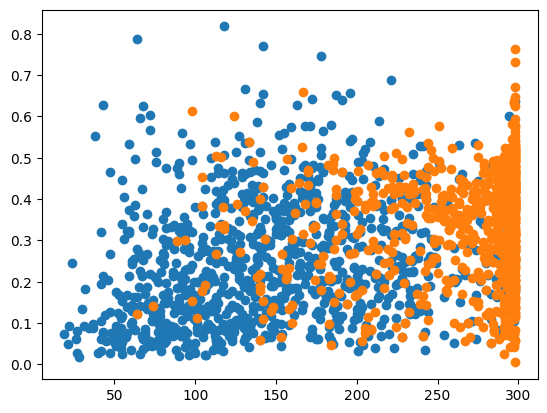

In [67]:
plt.scatter(df["x"][df["is_adversarial"] == 0], df["y"][df["is_adversarial"] == 0])
plt.scatter(df["x"][df["is_adversarial"] == 1], df["y"][df["is_adversarial"] == 1])

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

x_train, x_test, y_train, y_test = train_test_split(df[["x", "y", "class"]],
                                                    df["is_adversarial"],
                                                    stratify=df["is_adversarial"],
                                                    test_size=.2,
                                                    shuffle=True)

clf = LogisticRegression(random_state=0).fit(x_train[["x", "y"]], y_train)

C:\Users\koend\AppData\Local\Temp\ipykernel_15084\820216053.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(x_train["x"][y_train == 0], x_train["y"][y_train == 0], cmap="bwr", edgecolor="k", label="Benign")
C:\Users\koend\AppData\Local\Temp\ipykernel_15084\820216053.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(x_train["x"][y_train == 1], x_train["y"][y_train == 1], cmap="bwr", edgecolor="k", label="Adversarial")


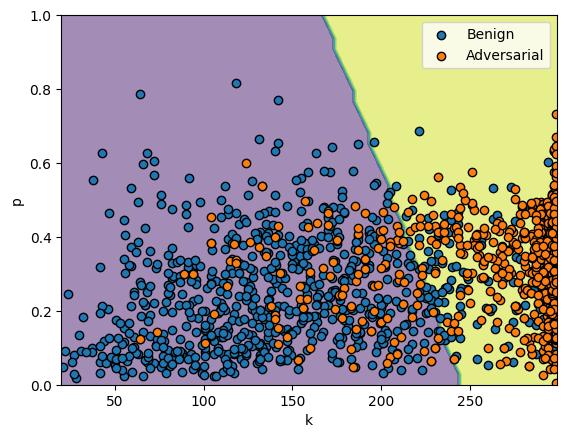

In [70]:
disp = DecisionBoundaryDisplay.from_estimator(clf, x_train[["x", "y"]], response_method="predict", xlabel="k", ylabel="p", alpha=.5)

disp.ax_.scatter(x_train["x"][y_train == 0], x_train["y"][y_train == 0], cmap="bwr", edgecolor="k", label="Benign")
disp.ax_.scatter(x_train["x"][y_train == 1], x_train["y"][y_train == 1], cmap="bwr", edgecolor="k", label="Adversarial")
# plt.set_cmap("brg")
# disp.ax_.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, edgecolor="k")
plt.ylim(0, 1)
plt.legend()

In [67]:
preds = clf.predict(x_test)

In [111]:
type(preds)

numpy.ndarray

In [71]:
preds = clf.predict(x_test[["x", "y"]])

final_predictions = []
real_predictions = []
for i in range(len(x_test)):
    org_idx = x_test.iloc[i].name
    image, noise, label, _, _ = dataset[org_idx % 1000]

    real_predictions.append(label)

    if preds[i]:
        final_predictions.append(x_test.iloc[i]["class"])
    else:
        if org_idx >= 1000:
            image = image + noise
        temp_output = model(image[None])
        _, c = torch.max(temp_output, dim=1)
        final_predictions.append(c)


In [72]:
corr = 0

for i in range(len(final_predictions)):
    eq = final_predictions[i] == real_predictions[i]

    if eq: corr+=1

In [73]:
corr

331

In [74]:
len(final_predictions)

400